In [12]:
import numpy as np
import pandas as pd
from pathlib import Path
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("talk") # "paper" or "talk"
from tqdm.auto import tqdm
from scipy.stats import norm

In [4]:
data_path = Path('./results_csv/')
data = []
for file in tqdm(data_path.iterdir(), desc="Reading data", total=len(list(data_path.iterdir()))):
    metadata = file.stem.split('_')
    liquids = int(metadata[metadata.index('liquids') + 1])
    size = int(metadata[metadata.index('size') + 1])
    raw_data = pd.read_csv(file, header=None, names=[f"{i}" for i in range(liquids + 1)])
    raw_data.drop(f"{liquids}", axis=1, inplace=True)
    frame = pd.DataFrame(columns=["total_liquids", "size", "percolated_liquids", "first_percolated"])
    frame["first_percolated"] = raw_data["0"]
    frame["percolated_liquids"] = raw_data.sum(axis=1)
    frame["size"] = size
    frame["total_liquids"] = liquids
    data.append(frame)

data = pd.concat(data)


Reading data:   0%|          | 0/4103 [00:00<?, ?it/s]

In [5]:
max(data.total_liquids.unique())

121

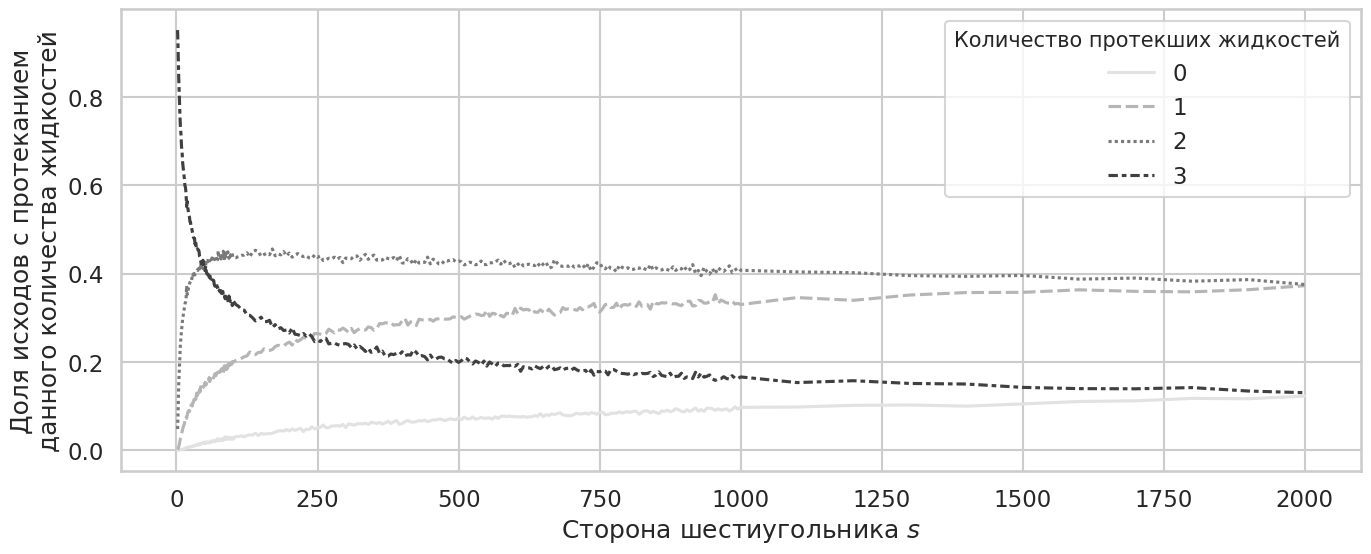

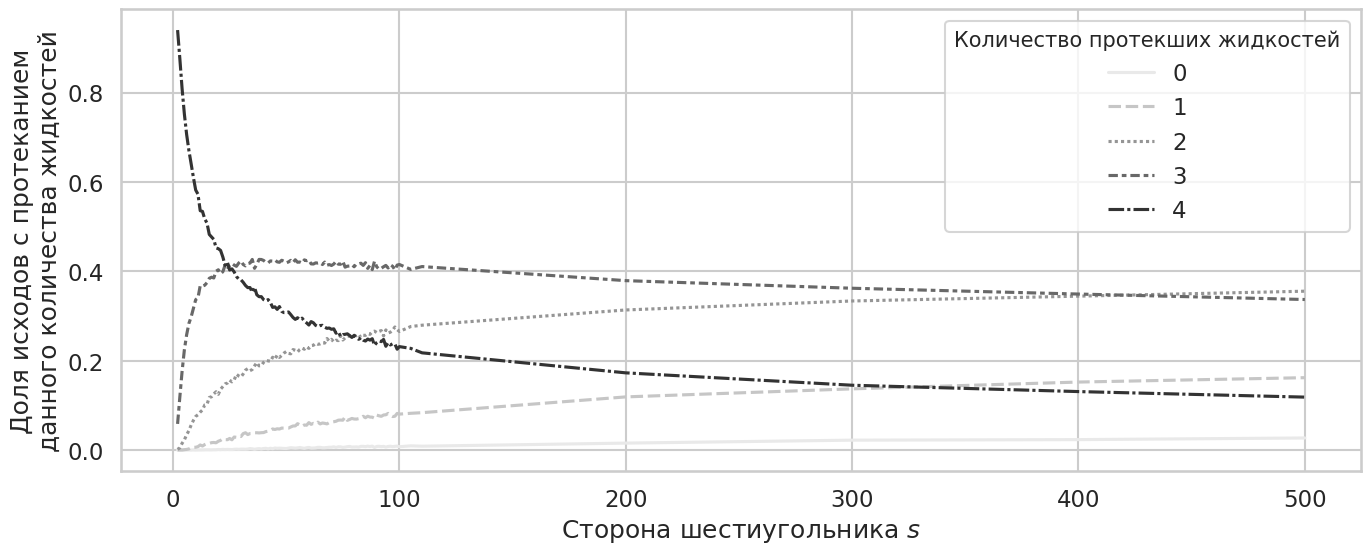

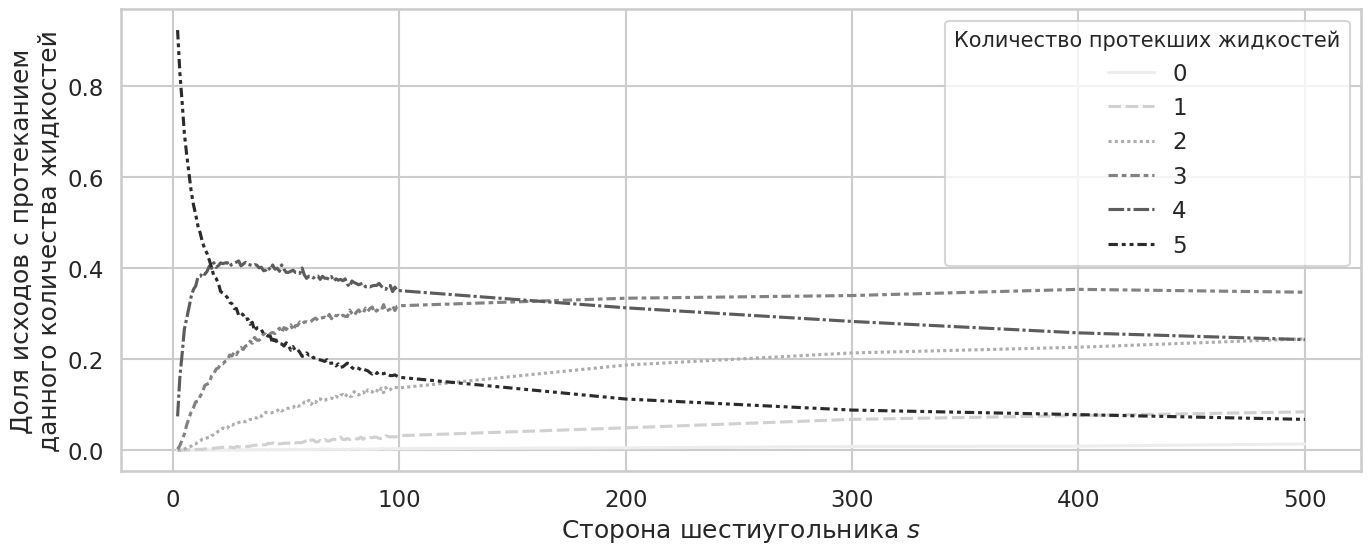

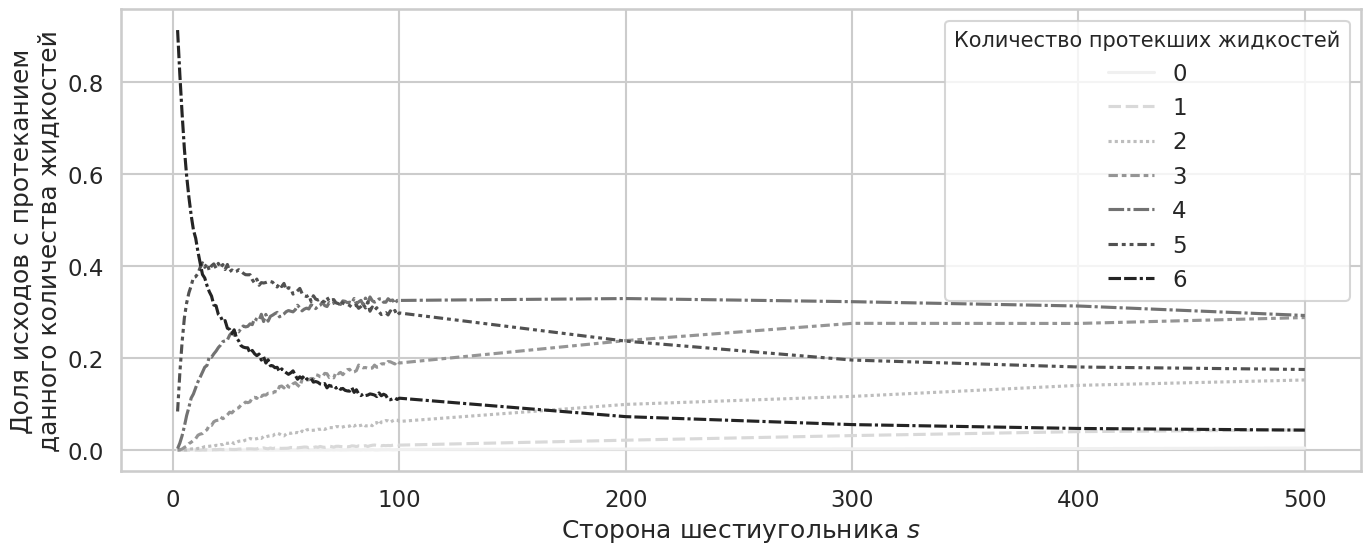

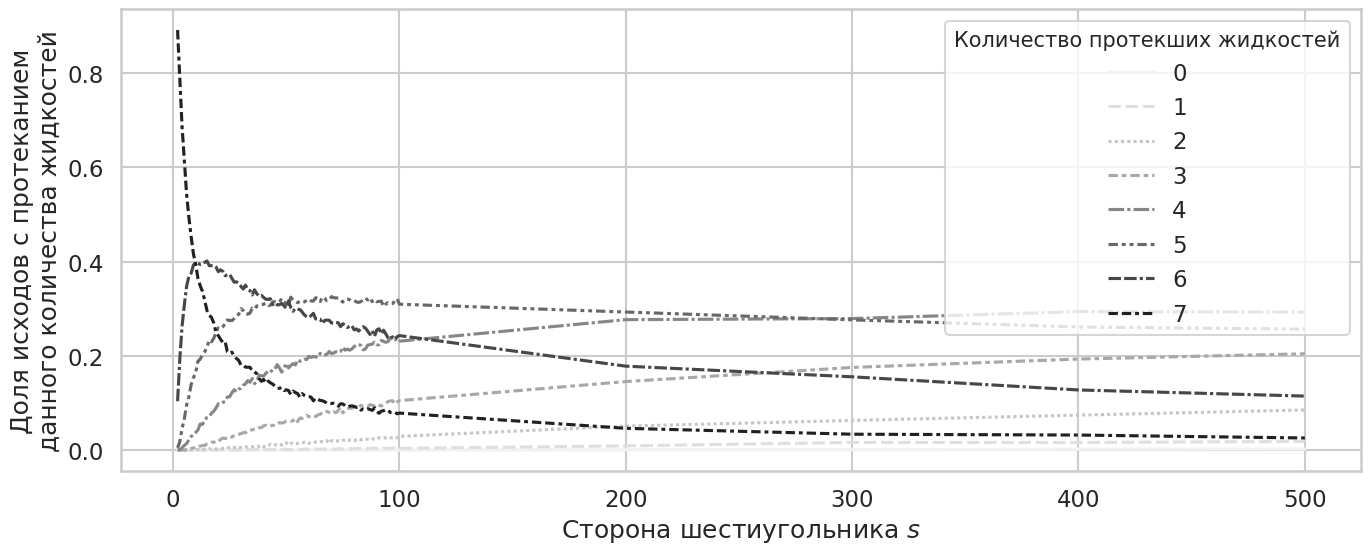

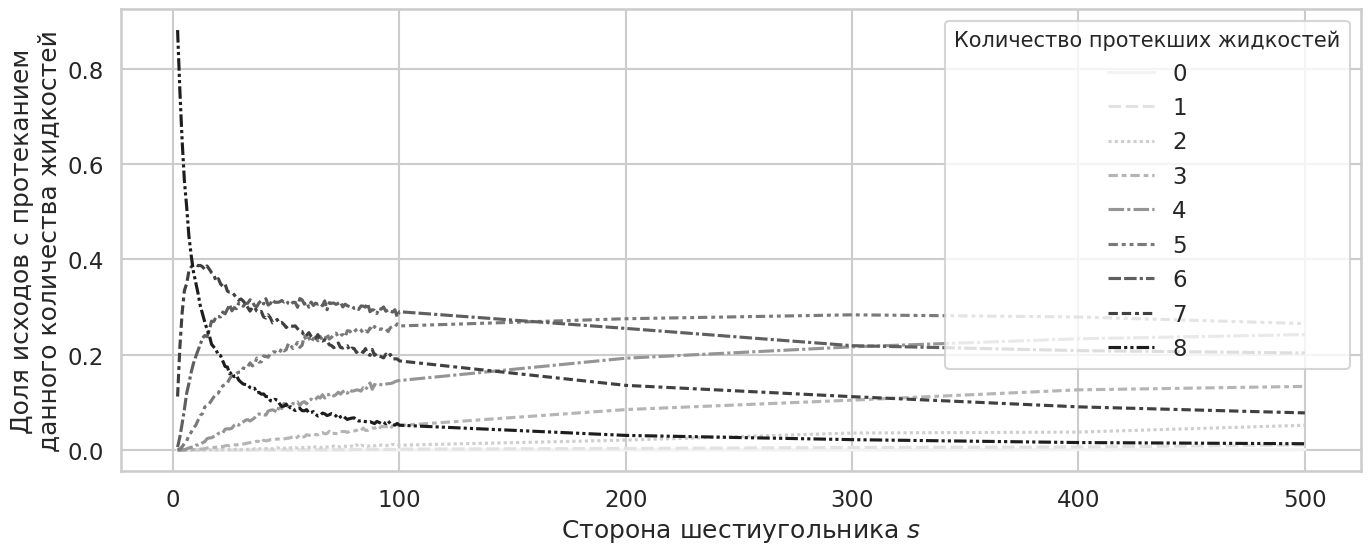

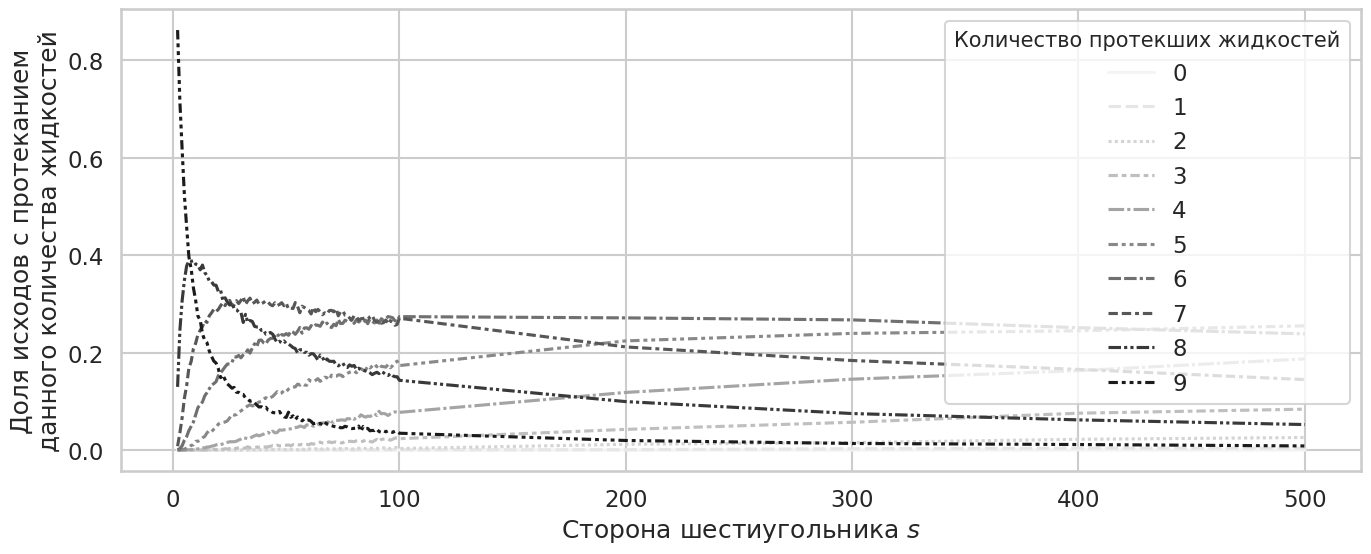

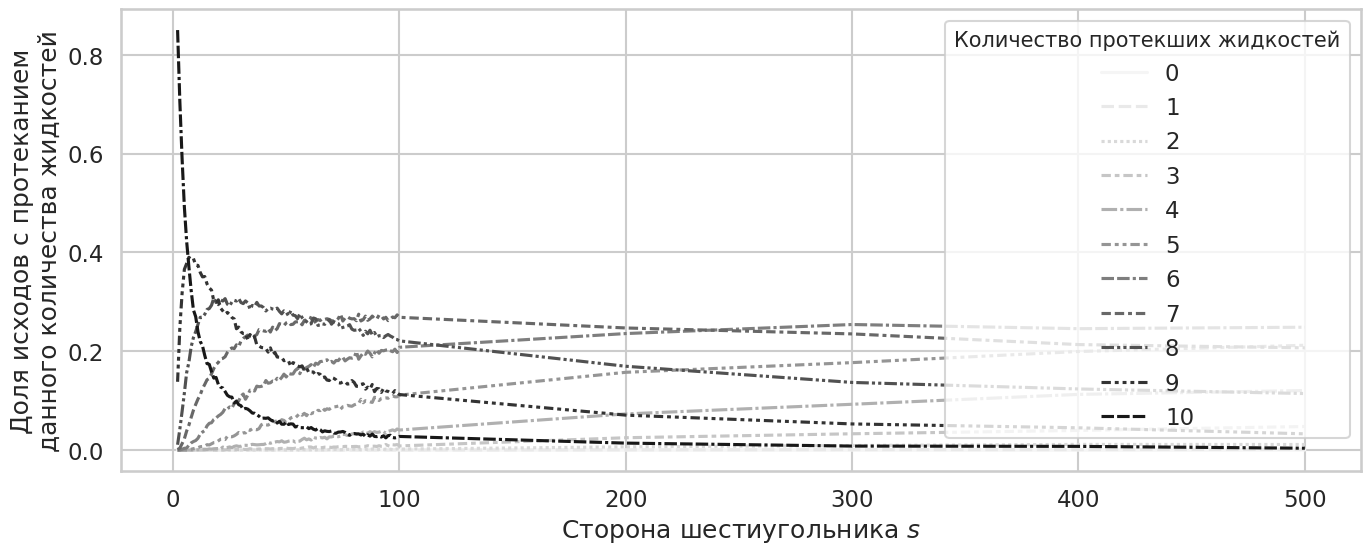

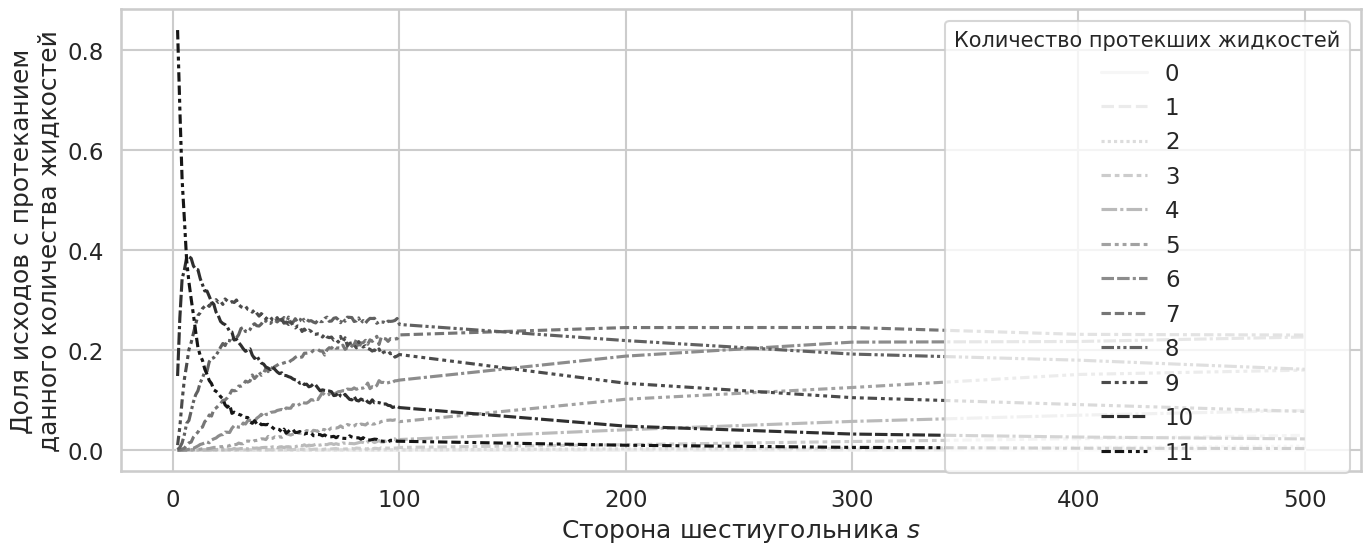

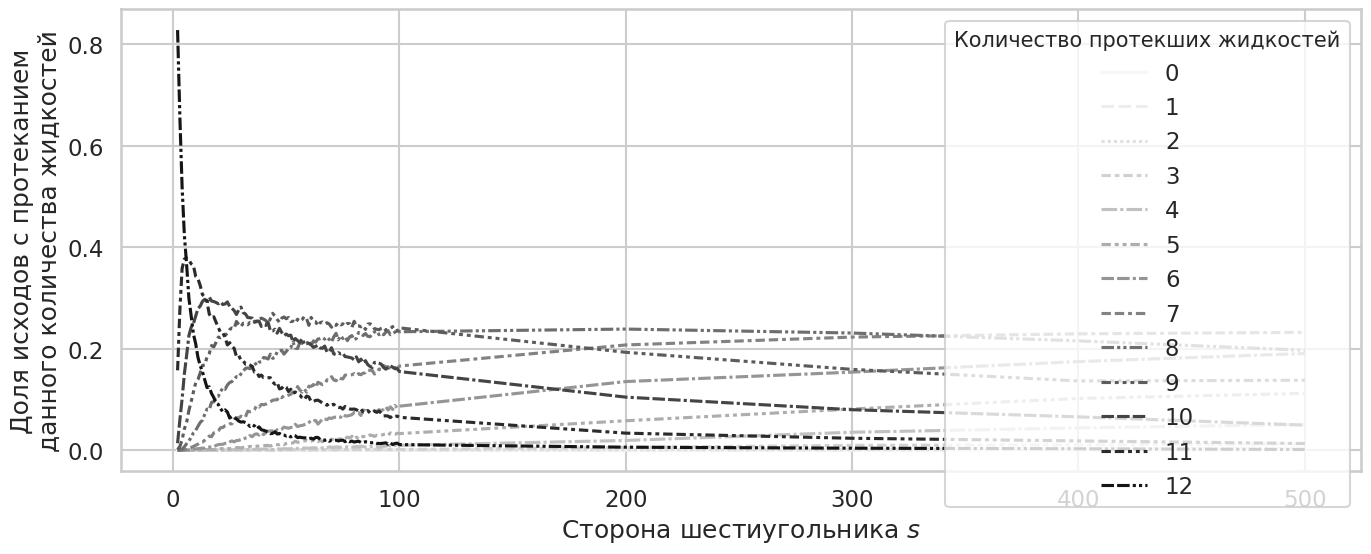

In [13]:
for liquid in sorted(data.total_liquids.unique()):
    if liquid > 12:
        break
    plt.figure(figsize=(16, 6))
    sns.lineplot(data=data[data.total_liquids == liquid].groupby('size')["percolated_liquids"].value_counts(normalize=True).unstack().fillna(0),
                 palette=('Greys'))
    plt.ylabel('Доля исходов с протеканием\nданного количества жидкостей')
    plt.xlabel('Сторона шестиугольника $s$')
    plt.legend(title="Количество протекших жидкостей", title_fontsize="small")
#     plt.ylabel('Probability of a given number of liquids to percolate')
#     plt.xlabel('Size s of hexagon')
    plt.savefig(f'./output_images/percolation__liquids={liquid}.pdf', format="pdf")
    plt.show()

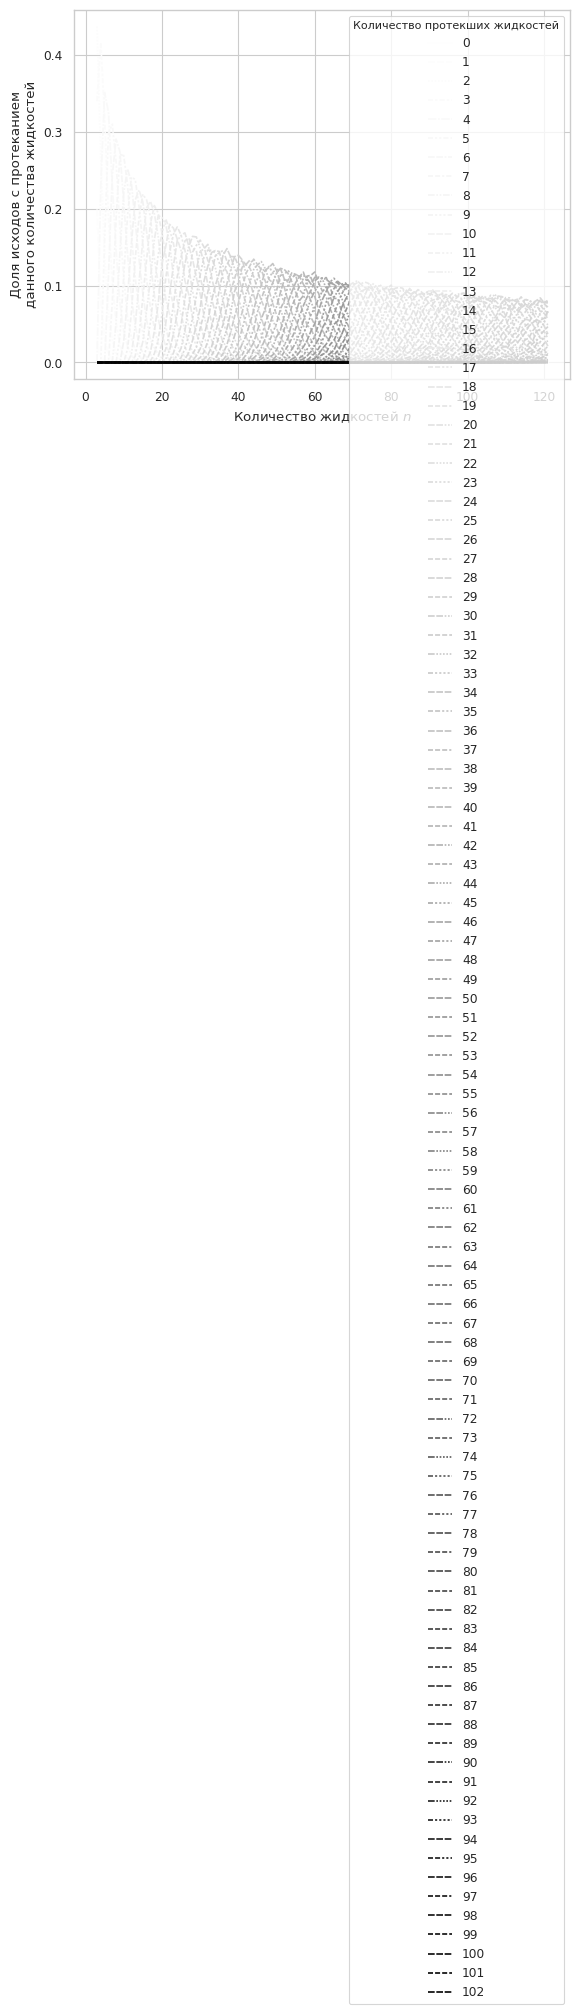

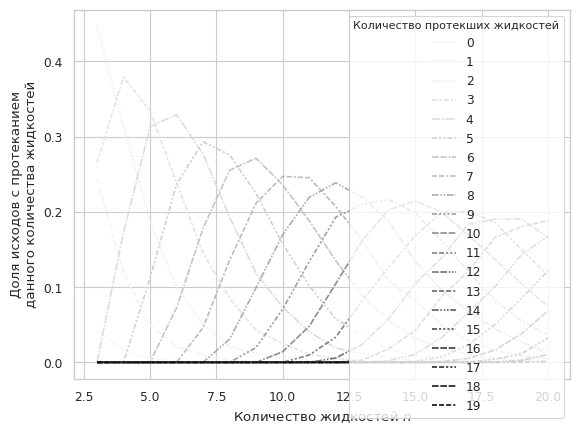

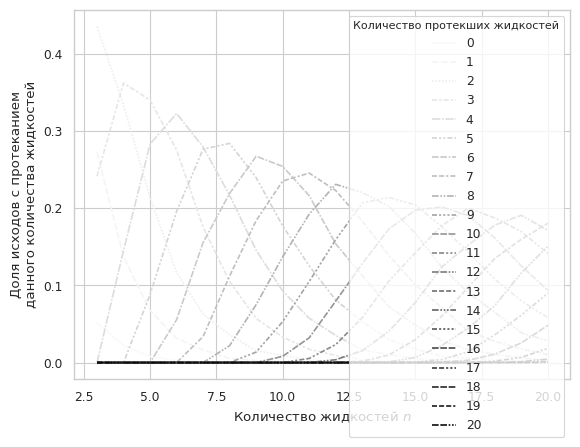

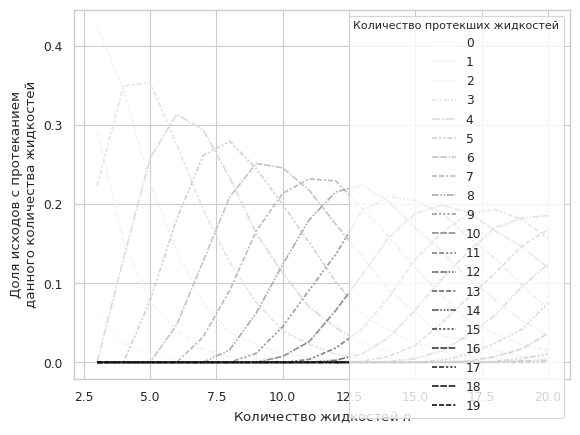

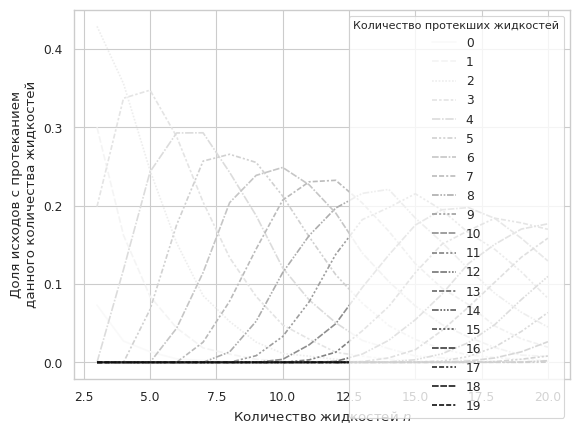

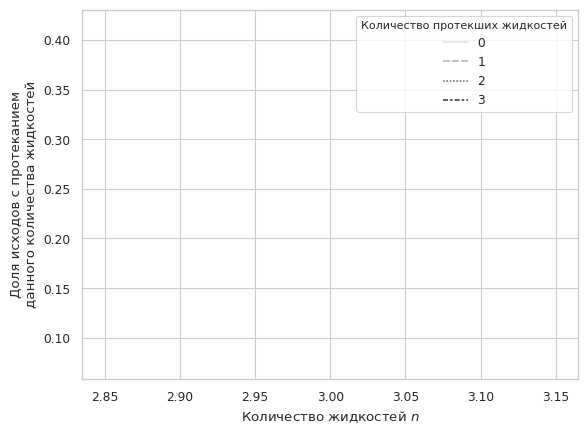

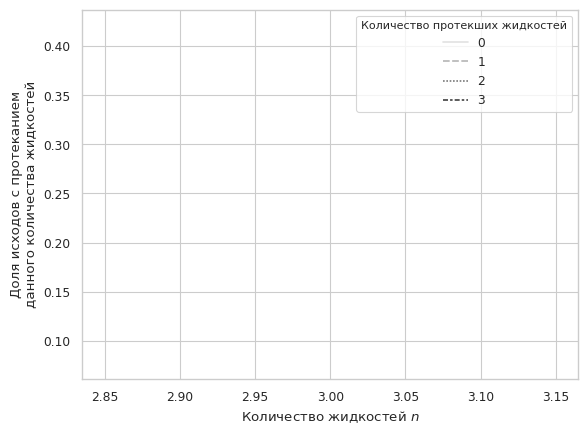

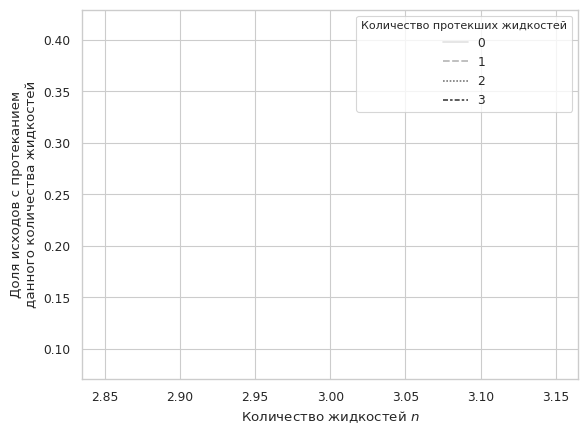

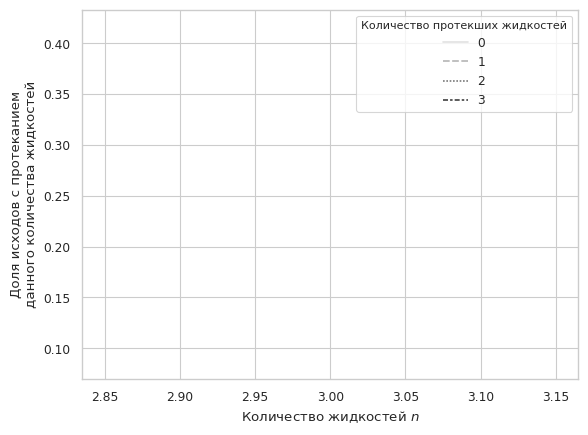

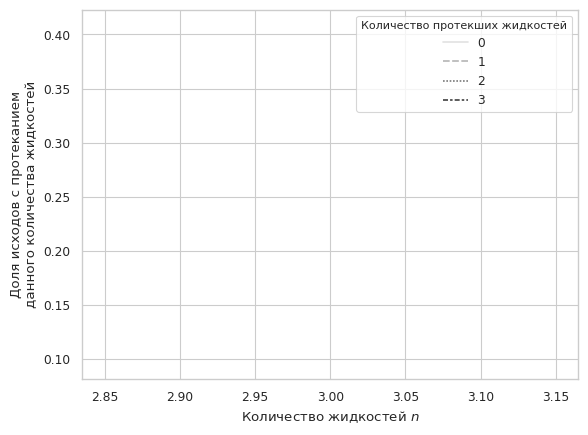

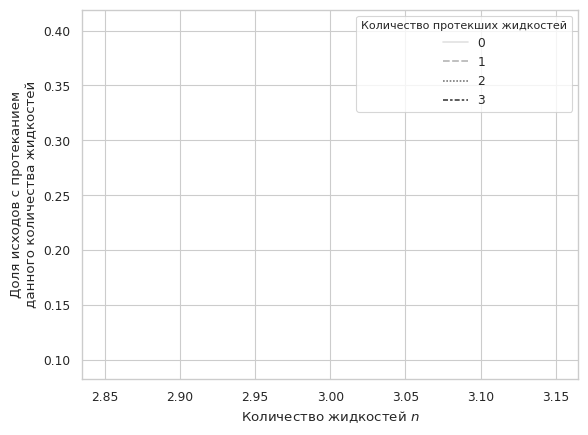

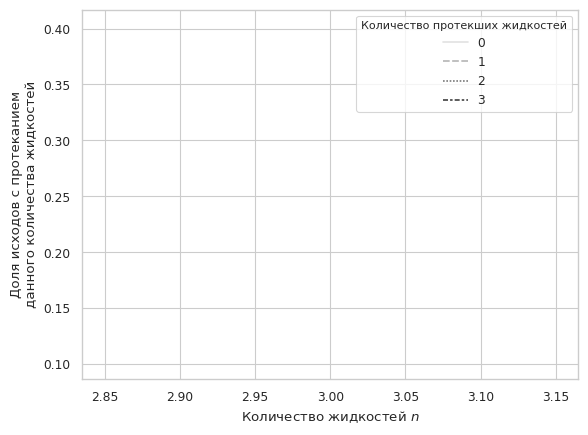

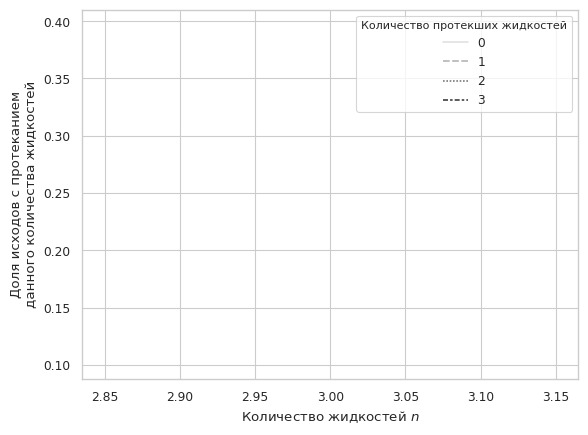

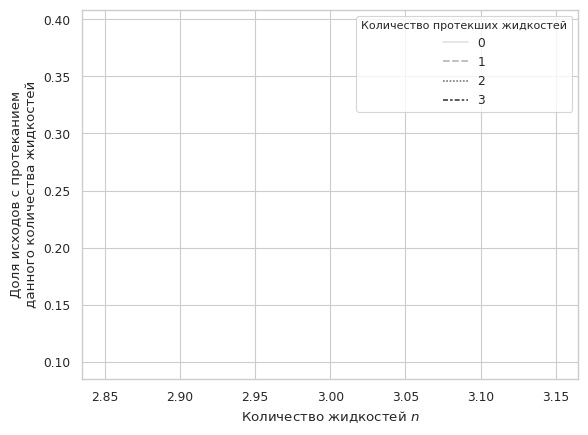

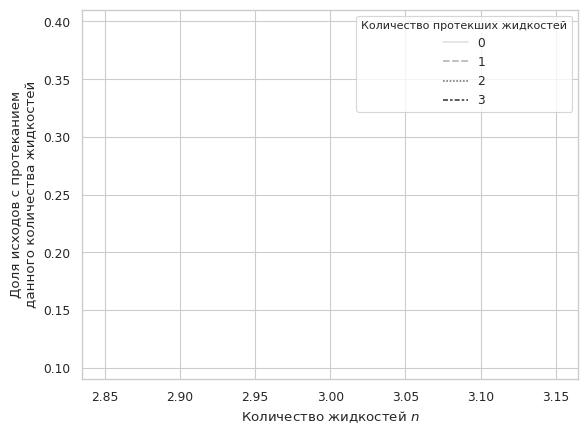

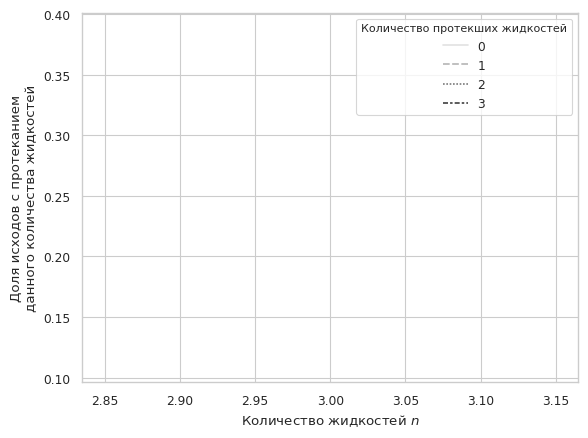

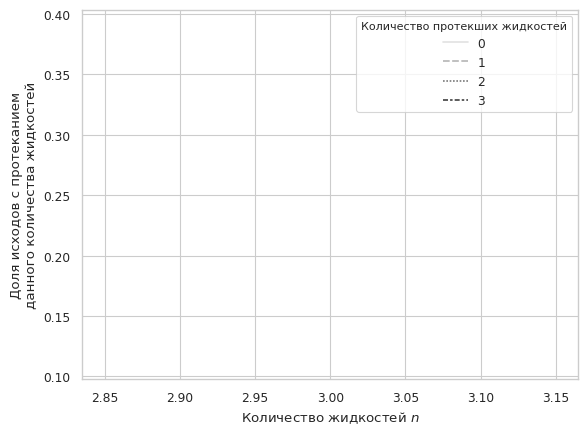

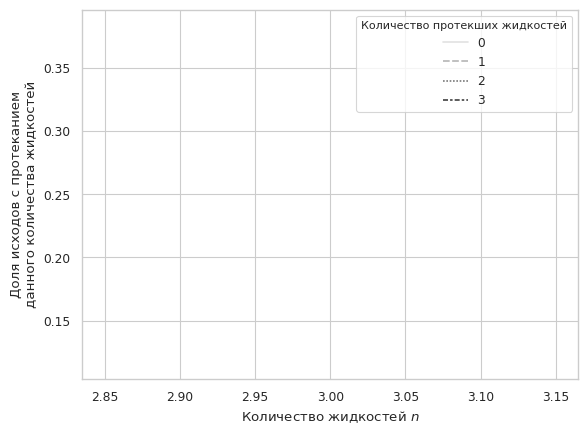

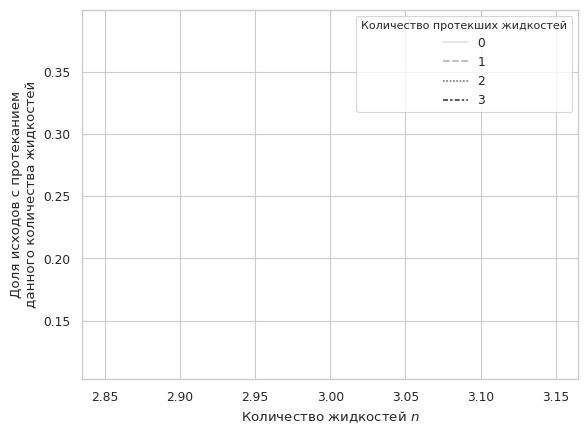

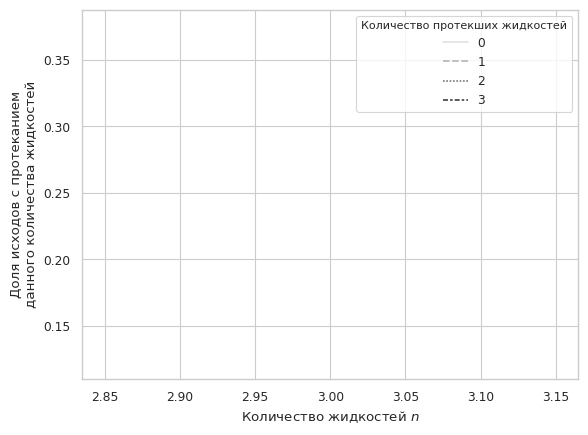

In [9]:
for hex_size in sorted(data['size'].unique()):
    if (hex_size % 100) != 0:
        continue
#     plt.figure(figsize=(16, 6))
    sns.lineplot(data=data[data['size'] == hex_size].groupby('total_liquids')["percolated_liquids"].value_counts(normalize=True).unstack().fillna(0),
                 palette=('Greys'))
    plt.ylabel('Доля исходов с протеканием\nданного количества жидкостей')
    plt.xlabel('Количество жидкостей $n$')
    plt.legend(title="Количество протекших жидкостей", title_fontsize="small")
#     plt.ylabel('Probability of a given number of liquids to percolate')
#     plt.xlabel('Size s of hexagon')
#     plt.savefig(f'./output_images/percolation__liquids={liquid}.pdf', format="pdf")
    plt.show()

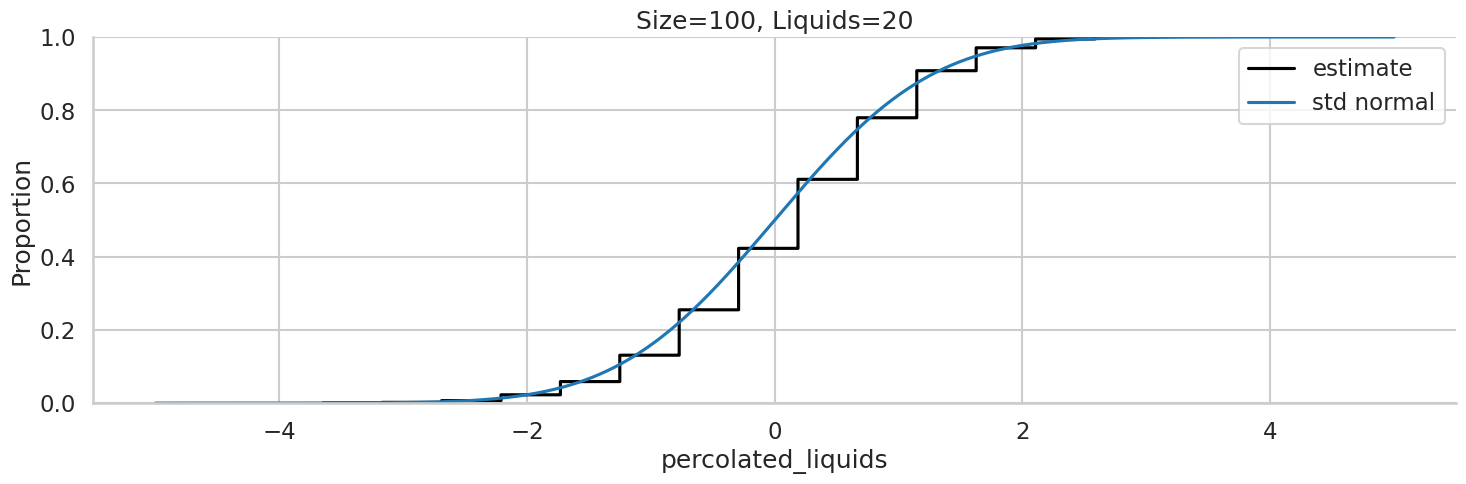

In [49]:
size = 100
liquids = 20
p_s = data[(data['size'] == size) & (data["total_liquids"] == liquids)].first_percolated.mean()
estimates = data[(data['size'] == size) & (data["total_liquids"] == liquids)]["percolated_liquids"] / (np.sqrt(liquids)) - np.sqrt(liquids) * p_s
estimates /= np.sqrt((1 - p_s) * p_s)
sns.displot(data=estimates,
            kind="ecdf",
            color='black',
            label="estimate",
            aspect=3)
x=np.linspace(-5, 5, num=1000)
plt.title(f"Size={size}, Liquids={liquids}")
plt.plot(x, norm.cdf(x), label='std normal')
plt.legend()

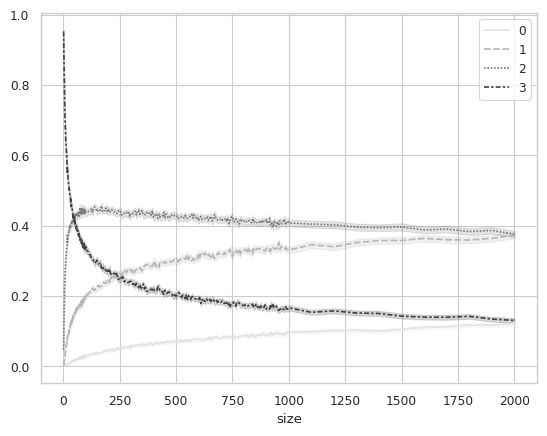

In [10]:
part = pd.get_dummies(data[data.total_liquids == 3].percolated_liquids)
part['size'] = data[data.total_liquids == 3]['size']
sns.lineplot(data=part.set_index('size'), palette=('Greys'))

# name = "liq_indep_3_eng"
# frm = "pdf"
plt.savefig(f'./output_images/percolation_with_confidence__liquids=3.pdf', format="pdf")

In [15]:
def get_bernoulli_confidence_interval(estimates, samples, confidence=0.95):
    quantile = norm.ppf(confidence)
    mid = (estimates + quantile ** 2 / samples / 2) / (1 + quantile ** 2 / samples)
    elbow = np.sqrt(estimates * (1 - estimates) / samples + quantile ** 2 / (4 * samples ** 2)) * quantile / (1 + quantile ** 2 / samples)
    return np.vstack([np.maximum(mid - elbow, 0), np.minimum(mid + elbow, 1)])

In [5]:
confidence_level = 0.95
for liquid in sorted(data.total_liquids.unique()):
    part = data[(data.total_liquids == liquid) & (data['size'] % 5 == 0)]
    probs_all = part.groupby("size")["percolated_liquids"].value_counts(normalize=True).unstack().fillna(0)[liquid]
    probs_one = part.groupby("size")["first_percolated"].mean()

    bounds_all = get_bernoulli_confidence_interval(probs_all, 10000, confidence=np.sqrt(confidence_level))
    bounds_one = get_bernoulli_confidence_interval(probs_one, 10000, confidence=np.sqrt(confidence_level))
    values = probs_all / (probs_one ** liquid)
    bounds = bounds_all / (bounds_one[::-1, :] ** liquid)

    errors = np.abs(bounds - values.values)
    fig = plt.figure(figsize=(16,6))
    plt.errorbar(probs_all.index, values, capsize=2, yerr=errors, label='', color='black', elinewidth=0.5)
    plt.ylabel('Ratio of probability of all liquids to percolate\nto n-th power of probability first liquid percolate')
    plt.xlabel('Size s of hexagon')
    plt.savefig(f'./output_images/ratio_all_to_one__liquids={liquid}_confidence={confidence_level}.pdf', format="pdf")
    plt.close(fig)

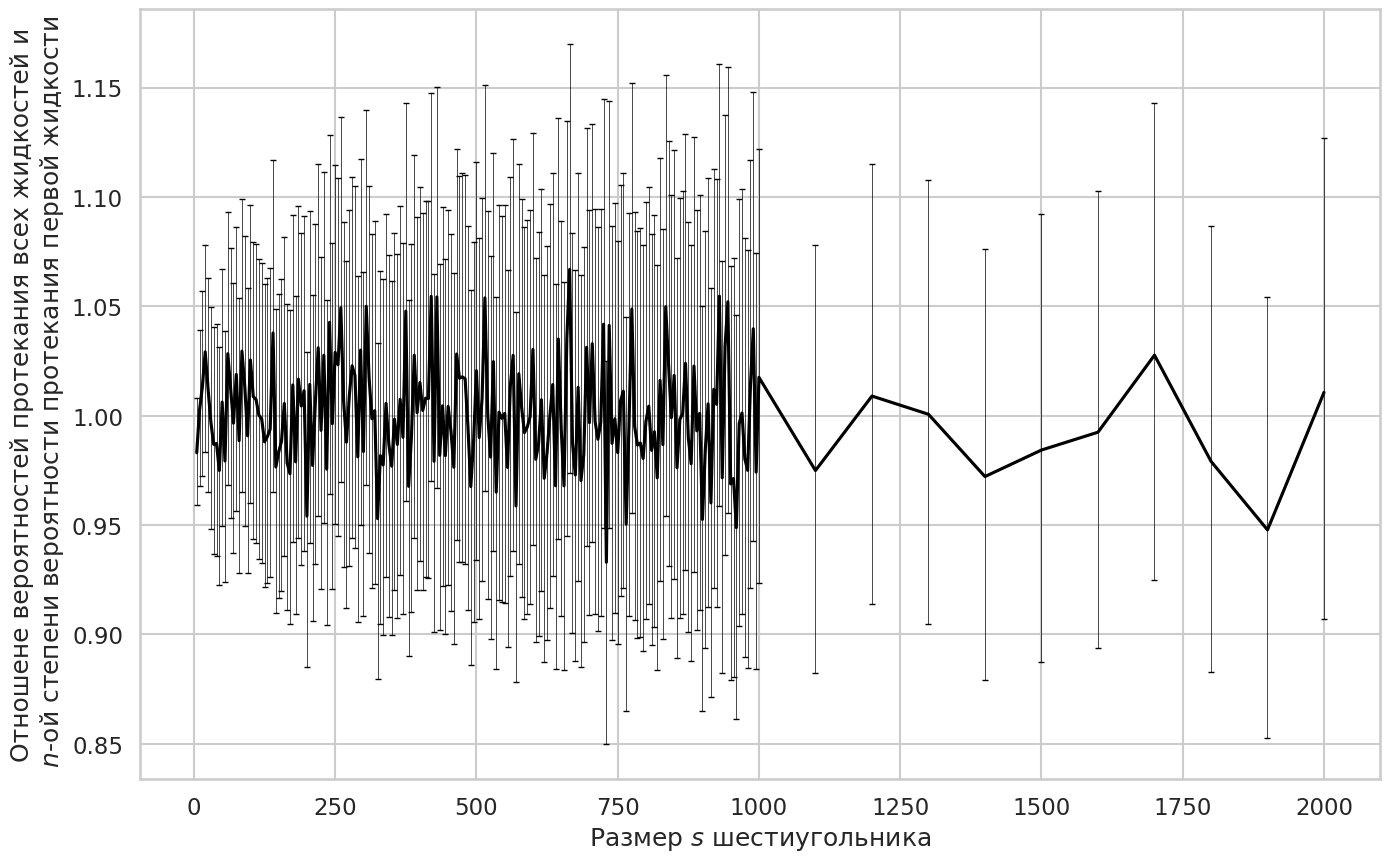

In [22]:
liquid = 3
confidence_level = 0.95
part = data[(data.total_liquids == liquid) & (data['size'] % 5 == 0)]
probs_all = part.groupby("size")["percolated_liquids"].value_counts(normalize=True).unstack().fillna(0)[liquid]
probs_one = part.groupby("size")["first_percolated"].mean()
samples = 10000
bounds_all = get_bernoulli_confidence_interval(probs_all, samples, confidence=np.sqrt(confidence_level))
bounds_one = get_bernoulli_confidence_interval(probs_one, samples, confidence=np.sqrt(confidence_level))
values = probs_all / (probs_one ** liquid)
bounds = bounds_all / (bounds_one[::-1, :] ** liquid)

errors = np.abs(bounds - values.values)
fig = plt.figure(figsize=(16,10))
plt.errorbar(probs_all.index, values, capsize=2, yerr=errors, label='', color='black', elinewidth=0.5)
# plt.ylabel('Ratio of probability of all liquids to percolate\nto n-th power of probability first liquid percolate')
# plt.xlabel('Size s of hexagon')
plt.ylabel('Отношене вероятностей протекания всех жидкостей и\n $n$-ой степени вероятности протекания первой жидкости')
plt.xlabel('Размер $s$ шестиугольника')
plt.savefig(f'./output_images/ratio_all_to_one__liquids={liquid}_confidence={confidence_level}.pdf', format="pdf")


In [ ]:
sns.lineplot(data=data[data['size'] % 100 == 0], x="liquids", y="first_percolated", hue="size")

In [6]:
for key in range(min(data.keys()), max(data.keys()) + 1):
    data_part = data[key]
    counts = data_part.groupby(['size', 'total']).count()['0'].unstack().fillna(0)
    means = counts.div(counts.sum(axis=1), axis=0)
    fig = go.Figure()
    for name in means.columns:
        fig.add_trace(go.Scatter(
            name=name,
            x=means[name].index,
            y=means[name],
            # error_y=dict(
            #     type='data', # value of error bar given in data coordinates
            #     array=(means[name] - means[name] ** 2) / 30,
            #     visible=True)
        ))
    # fig = counts.div(counts.sum(axis=1), axis=0).plot(title=f"Percolation of {key} liquids.")
    fig.show()


In [ ]:
key = 3
fig = data[key].drop('total', axis=1).set_index('size').stack().reset_index().astype('float').plot(labels=dict(index="size", value="0", variable="level_1"))
fig.show()

In [ ]:
sns.lineplot(data=data[3], x="size", hue="total")

In [ ]:
key = 5values = (all_prob / one_prob ** key)

counts = data[key].groupby(['size', 'total']).count().mean(axis=1).unstack().fillna(0)
all_prob = counts.div(counts.sum(axis=1), axis=0)[key]
one_prob = data[key].drop('total', axis=1).groupby('size').mean()['0']
values = (all_prob / one_prob ** key)
std_diviations = (2 * (all_prob - all_prob ** 2) + 1e-4) / (one_prob ** (2 * key)) / 1000
fig = go.Figure([
    go.Scatter(
        name='Measurement',
        x=values.index,
        y=values,
        mode='lines',
        line=dict(color='rgb(31, 119, 180)'),
    ),
    go.Scatter(
        name='Upper Bound',
        x=values.index,
        y=(values + std_diviations).apply(lambda x: min(x, 20)),
        mode='lines',
        marker=dict(color="#444"),
        line=dict(width=0),
        showlegend=False
    ),
    go.Scatter(
        name='Lower Bound',
        x=values.index,
        y=(values - std_diviations).apply(lambda x: max(0, x)),
        marker=dict(color="#444"),
        line=dict(width=0),
        mode='lines',
        fillcolor='rgba(68, 68, 68, 0.3)',
        fill='tonexty',
        showlegend=False
    )
])
fig.update_layout(
    yaxis_title='Wind speed (m/s)',
    title='Continuous, variable value error bars',
    hovermode="x"
)
fig.show()

In [ ]:
counts = data[5].groupby(['size', 'total']).std().mean(axis=1).unstack().fillna(0)
counts

0         1         2         3         4
size total                                                  
5    0           NaN       NaN       NaN       NaN       NaN
     1      0.430851  0.162221  0.471069  0.369537  0.446258
     2      0.484230  0.491444  0.491000  0.494249  0.490080
     3      0.492949  0.488151  0.488151  0.490392  0.490071
     4      0.399536  0.393154  0.401723  0.398244  0.407221
...              ...       ...       ...       ...       ...
740  1      0.527046  0.440959  0.000000  0.333333  0.440959
745  0      0.000000  0.000000  0.000000  0.000000  0.000000
     1      0.487950  0.487950  0.000000  0.534522  0.000000
750  0      0.000000  0.000000  0.000000  0.000000  0.000000
     1      0.377964  0.000000  0.377964  0.487950  0.534522

[528 rows x 5 columns]